In [1]:
# this is good code

Fixed S=1.0: Estimated C = [1.90785656 1.76549364], Loss = 1.1088
Optimized S: Estimated C = [1.76746313 1.92786507], S = 2.5719, Loss = 0.6282


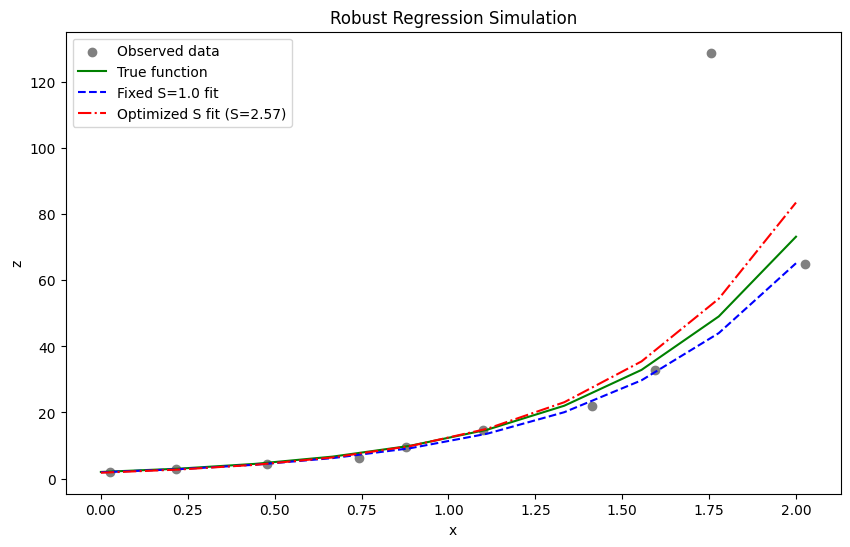

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# # Simulate data
# np.random.seed(42)
# N = 50
# x_true = np.linspace(0, 2, N)
# C_true = np.array([2.0, 1.5])  # true parameters
# z_true = C_true[0] * np.exp(C_true[1] * x_true)

# # Add noise and outliers
# x_obs = x_true + np.random.normal(0, 0.05, N)
# Z_obs = z_true + np.random.normal(0, 0.6, N)
# Z_obs[::10] += np.random.normal(5, 1, N // 10)  # inject outliers every 10th point
# Set random seed
np.random.seed(42)

# True function: nonlinear
def true_function(x):
    return 2.0 * np.exp(1.8 * x)

# Generate input data
N = 10
x_true = np.linspace(0, 2, N)
z_true = true_function(x_true)

# Add small Gaussian noise
x_obs = x_true + np.random.normal(0, 0.05, N)
Z_obs = z_true + np.random.normal(0, 0.2, N)

# Introduce 2 outliers (indices 3 and 7)
outlier_indices = [8, 9]
Z_obs[outlier_indices] += np.array([80.0, -8.0])  # one high outlier, one low

# Robust regression components
def F(C, x):
    return C[0] * np.exp(C[1] * x)

def compute_q(Zn, z0n, S):
    return (Zn / z0n) ** (1 / S)

def compute_hi(qn):
    return (qn ** 2 - qn ** -2) / (qn ** 2 + qn ** -2)

def criterion(C, S, x_obs, Z_obs):
    z0 = F(C, x_obs)
    qn = compute_q(Z_obs, z0, S)
    hi = compute_hi(qn)
    # print(f"hi: {hi}")
    D_hi = hi ** 2  # simple quadratic loss
    return np.sum(D_hi)

# Optimize C for fixed S
def fit_robust_regression(x_obs, Z_obs, S=1.0):
    C0_init = np.array([1.0, 1.0])  # initial guess
    res = minimize(criterion, C0_init, args=(S, x_obs, Z_obs), method='BFGS')
    return res.x, res.fun

# Optional: tune S as well
def joint_optimization(x_obs, Z_obs):
    def joint_obj(params):
        C = params[:2]
        S = np.abs(params[2]) + 1e-6  # keep S positive
        return criterion(C, S, x_obs, Z_obs) + 0.1 * S  # regularize S to avoid trivial S→∞

    params_init = np.array([1.0, 1.0, 1.0])
    res = minimize(joint_obj, params_init, method='BFGS')
    C_opt = res.x[:2]
    S_opt = np.abs(res.x[2]) + 1e-6 
    m2pi = 2 / np.pi ## addition NOTE
    S_opt = S_opt * m2pi  # scale S to match original scale
    return C_opt, S_opt, res.fun

# Run fixed S optimization
S_fixed = 1.0
C_est, loss_val = fit_robust_regression(x_obs, Z_obs, S_fixed)
print(f"Fixed S={S_fixed}: Estimated C = {C_est}, Loss = {loss_val:.4f}")

# Run joint optimization
C_opt, S_opt, loss_opt = joint_optimization(x_obs, Z_obs)
print(f"Optimized S: Estimated C = {C_opt}, S = {S_opt:.4f}, Loss = {loss_opt:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(x_obs, Z_obs, color='gray', label='Observed data')
plt.plot(x_true, z_true, 'g-', label='True function')
plt.plot(x_true, F(C_est, x_true), 'b--', label=f'Fixed S={S_fixed} fit')
plt.plot(x_true, F(C_opt, x_true), 'r-.', label=f'Optimized S fit (S={S_opt:.2f})')
plt.legend()
plt.xlabel('x')
plt.ylabel('z')
plt.title('Robust Regression Simulation')
plt.show()


In [3]:
# The code simulates a nonlinear regression problem with outliers and applies a robust regression method to fit the data.
# It uses the BFGS optimization algorithm to minimize a custom loss function that accounts for outliers.
# The results are visualized with a plot showing the observed data, true function, and fitted curves.
# The code is structured to allow for both fixed and joint optimization of the parameters.
# The joint optimization includes a regularization term to avoid trivial solutions.

Robust regression (fixed S=1.0): C = [1.89691277 1.61324586], Loss = 2.0785
Optimized S: Estimated C = [4.27720626 0.73012703], S = 6.5372, Loss = 1.6430


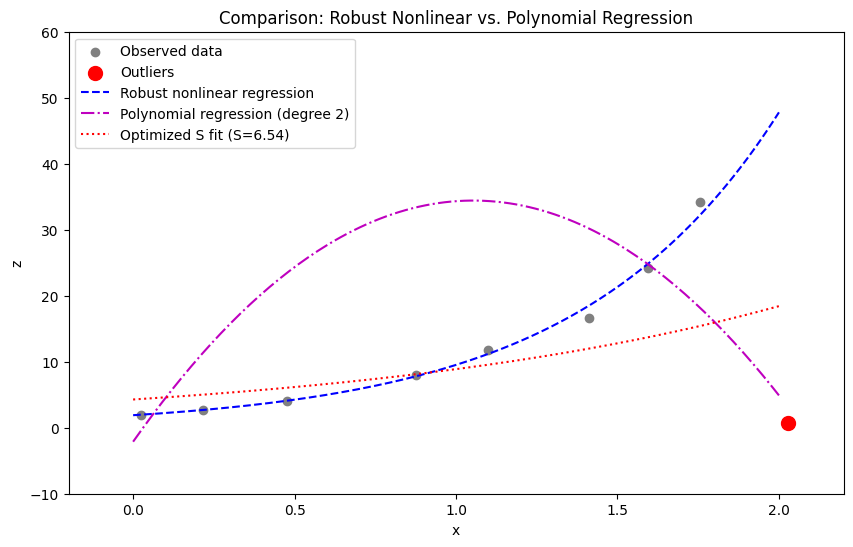

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set random seed
np.random.seed(42)

# True nonlinear function
def true_function(x):
    return 2.0 * np.exp(1.6 * x) # try with 1.2, 1.8, 2.0, 2.5 --> it shows importance of the S parameter

# Generate small dataset with 10 points
N = 10
x_true = np.linspace(0, 2, N)
z_true = true_function(x_true)

# Add small Gaussian noise
x_obs = x_true + np.random.normal(0, 0.05, N)
Z_obs = z_true + np.random.normal(0, 0.2, N)

# Inject 2 outliers at index 3 and 7
outlier_indices = [3, 9]
Z_obs[outlier_indices] += np.array([100.0, -48.0])
# convert data additive to multiplicative
# Z_obs = np.exp(Z_obs)  # convert to multiplicative noise

# Define robust nonlinear model
def F(C, x):
    return C[0] * np.exp(C[1] * x)

def compute_q(Zn, z0n, S):
    return (Zn / z0n) ** (1 / S)

def compute_hi(qn):
    return (qn ** 2 - qn ** -2) / (qn ** 2 + qn ** -2 + 1e-5)  # avoid division by zero

def criterion(C, S, x_obs, Z_obs):
    z0 = F(C, x_obs)
    qn = compute_q(Z_obs, z0, S)
    hi = compute_hi(qn)
    D_hi = hi ** 2
    return np.sum(D_hi)

# Fit robust nonlinear regression
def fit_robust_regression(x_obs, Z_obs, S=1.0):
    C0_init = np.array([1.0, 1.0])
    res = minimize(criterion, C0_init, args=(S, x_obs, Z_obs), method='BFGS')
    return res.x, res.fun

# Fit polynomial regression (degree 2)
def fit_polynomial_regression(x_obs, Z_obs, degree=2):
    coeffs = np.polyfit(x_obs, Z_obs, degree)
    poly_fn = np.poly1d(coeffs)
    return poly_fn

# Run robust regression
S_fixed = 1.0
C_est, loss_val = fit_robust_regression(x_obs, Z_obs, S_fixed)
print(f"Robust regression (fixed S={S_fixed}): C = {C_est}, Loss = {loss_val:.4f}")

# Run polynomial regression
poly_fn = fit_polynomial_regression(x_obs, Z_obs, degree=2)

# Run joint optimization
C_opt, S_opt, loss_opt = joint_optimization(x_obs, Z_obs)
print(f"Optimized S: Estimated C = {C_opt}, S = {S_opt:.4f}, Loss = {loss_opt:.4f}")


# Generate smooth x for plotting
x_plot = np.linspace(0, 2, 200)
z_true_plot = true_function(x_plot)
z_robust_plot = F(C_est, x_plot)
z_poly_plot = poly_fn(x_plot)

# Plot everything
plt.figure(figsize=(10, 6))
plt.scatter(x_obs, Z_obs, color='gray', label='Observed data')
plt.scatter(x_obs[outlier_indices], Z_obs[outlier_indices], color='red', s=100, label='Outliers')
# plt.plot(x_plot, z_true_plot, 'g-', label='True function')
plt.plot(x_plot, z_robust_plot, 'b--', label='Robust nonlinear regression')
plt.plot(x_plot, z_poly_plot, 'm-.', label='Polynomial regression (degree 2)')
plt.plot(x_plot, F(C_opt, x_plot), 'r:', label=f'Optimized S fit (S={S_opt:.2f})')
plt.xlim(-0.2, 2.2)
plt.ylim(-10, 60)
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.title('Comparison: Robust Nonlinear vs. Polynomial Regression')
plt.show()


In [5]:
# adding logic of local scale parameter S

In [6]:
import numpy as np

class LocalScaleEstimator:
    def __init__(self, Z, W=1, window=None, minwidth=1):
        self.Z = np.asarray(Z, dtype=np.float64)
        self.n = len(self.Z)
        
        if np.any(self.Z <= 0):
            raise ValueError("All elements in Z must be positive")
        if not np.all(np.diff(self.Z) >= 0):
            raise ValueError("Z must be sorted in ascending order")

        # Handle weights
        if np.isscalar(W):
            self.W = np.full(self.n, W)
        else:
            self.W = np.asarray(W, dtype=np.float64)
            if len(self.W) != self.n:
                raise ValueError("W must be a scalar or same length as Z")
        self.set_window_params(window, minwidth)

    def set_window_params(self, window, minwidth):
        n = self.n
        if minwidth < 1:
            minwidth = int(np.ceil(minwidth * n))
        else:
            minwidth = int(minwidth)

        if window is None:
            window = n
        elif window < 1:
            window = int(round(window * n))
        else:
            window = int(round(window))

        self.window = max(window, minwidth)
        self.minwidth = minwidth

    def compute_scale_vector(self):
        Z, W = self.Z, self.W
        n, w = self.n, self.window
        S = np.zeros(n)

        for i in range(n):
            n1 = max(0, i - w)
            n2 = min(n, i + w + 1)
            Z_slice = Z[n1:n2]
            W_slice = W[n1:n2]

            SWk = np.sum(W_slice)
            if SWk == 0:
                S[i] = self.GscaleLoc(1.0)
            else:
                r = Z_slice / Z[i]
                q = np.abs(1 - r ** (-0.5))
                q1 = np.abs(1 - r ** 0.5)
                F = np.sum(2 * W_slice / (q + q1)) / SWk
                S[i] = self.GscaleLoc(F)
        return S

    def GscaleLoc(self, F):
        """Solves sin(S) = S * F using Newton-Raphson, then returns 2S/pi."""
        m2pi = 2 / np.pi

        # Choose initial guess
        sqrt2 = np.sqrt(2)
        if F < m2pi * sqrt2 / 3:
            S = np.pi
        elif F < m2pi:
            S = 3 * np.pi / 4
        elif F < m2pi * sqrt2:
            S = np.pi / 2
        else:
            S = np.pi / 4

        epsilon = 1e-5
        max_iter = 100
        for _ in range(max_iter):
            delta = (np.sin(S) - S * F) / (np.cos(S) - F)
            S -= delta
            if abs(delta) < epsilon:
                break

        return S * m2pi


Fixed S=1.0: Estimated C = [1.60140076 2.28737318], Loss = 7.5753
Optimized S: Estimated C = [1. 1.], S = 1.0000, Loss = nan


/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/3293715360.py:41: RuntimeWarning: invalid value encountered in power
  return (Zn / z0n) ** (2 / S)


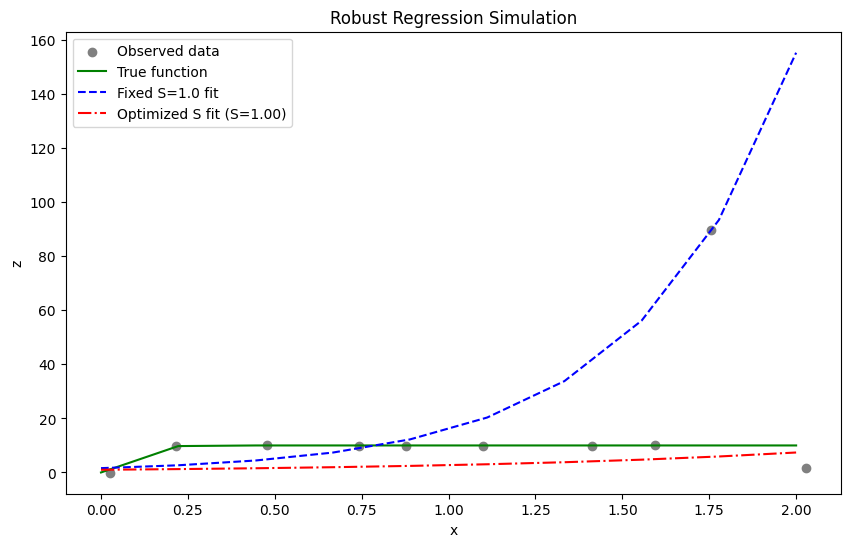

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# # Simulate data
# np.random.seed(42)
# N = 50
# x_true = np.linspace(0, 2, N)
# C_true = np.array([2.0, 1.5])  # true parameters
# z_true = C_true[0] * np.exp(C_true[1] * x_true)

# # Add noise and outliers
# x_obs = x_true + np.random.normal(0, 0.05, N)
# Z_obs = z_true + np.random.normal(0, 0.6, N)
# Z_obs[::10] += np.random.normal(5, 1, N // 10)  # inject outliers every 10th point
# Set random seed
np.random.seed(42)

# True function: nonlinear
def true_function(x):
    return 10.0 * np.tanh(10 * x)

# Generate input data
N = 10
x_true = np.linspace(0, 2, N)
z_true = true_function(x_true)

# Add small Gaussian noise
x_obs = x_true + np.random.normal(0, 0.05, N)
Z_obs = z_true + np.random.normal(0, 0.2, N)

# Introduce 2 outliers (indices 3 and 7)
outlier_indices = [8, 9]
Z_obs[outlier_indices] += np.array([80.0, -8.0])  # one high outlier, one low

# Robust regression components
def F(C, x):
    return C[0] * np.exp(C[1] * x)

def compute_q(Zn, z0n, S):
    return (Zn / z0n) ** (2 / S)

def compute_hi(qn):
    return (qn ** 2 - qn ** -2) / (qn ** 2 + qn ** -2)

def criterion(C, S, x_obs, Z_obs):
    z0 = F(C, x_obs)
    qn = compute_q(Z_obs, z0, S)
    hi = compute_hi(qn)
    # print(f"hi: {hi}")
    D_hi = hi ** 2  # simple quadratic loss
    return np.sum(D_hi)

# Optimize C for fixed S
def fit_robust_regression(x_obs, Z_obs, S=1.0):
    C0_init = np.array([1.0, 1.0])  # initial guess
    res = minimize(criterion, C0_init, args=(S, x_obs, Z_obs), method='BFGS')
    return res.x, res.fun

# Optional: tune S as well
def joint_optimization(x_obs, Z_obs):
    def joint_obj(params):
        C = params[:2]
        S = np.abs(params[2]) + 1e-6  # keep S positive
        return criterion(C, S, x_obs, Z_obs) + 0.1 * S  # regularize S to avoid trivial S→∞

    params_init = np.array([1.0, 1.0, 1.0])
    res = minimize(joint_obj, params_init, method='BFGS')
    C_opt = res.x[:2]
    S_opt = np.abs(res.x[2]) + 1e-6
    return C_opt, S_opt, res.fun

# Run fixed S optimization
S_fixed = 1.0
C_est, loss_val = fit_robust_regression(x_obs, Z_obs, S_fixed)
print(f"Fixed S={S_fixed}: Estimated C = {C_est}, Loss = {loss_val:.4f}")

# Run joint optimization
C_opt, S_opt, loss_opt = joint_optimization(x_obs, Z_obs)
print(f"Optimized S: Estimated C = {C_opt}, S = {S_opt:.4f}, Loss = {loss_opt:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(x_obs, Z_obs, color='gray', label='Observed data')
plt.plot(x_true, z_true, 'g-', label='True function')
plt.plot(x_true, F(C_est, x_true), 'b--', label=f'Fixed S={S_fixed} fit')
plt.plot(x_true, F(C_opt, x_true), 'r-.', label=f'Optimized S fit (S={S_opt:.2f})')
plt.legend()
plt.xlabel('x')
plt.ylabel('z')
plt.title('Robust Regression Simulation')
plt.show()


In [8]:
# writing MG regression check from scratch
# below points are important
# fi as w
# S - local scale optimization
# az conversion

In [9]:
def convert_az(a, lb, ub):
    """
    Converts additive data into the finite normalized multiplicative form.

    Parameters:
    ----------
    a : scalar or numpy.ndarray
        Input additive data.
    lb : float
        Lower bound (must be a scalar).
    ub : float
        Upper bound (must be a scalar).

    Returns:
    -------
    z : scalar or numpy.ndarray
        Data converted into finite normalized multiplicative form, 
        same type as 'a'.

    Raises:
    ------
    ValueError:
        If lb or ub is not a scalar.
    """
    if not np.isscalar(lb) or not np.isscalar(ub):
        raise ValueError("lb and ub must be scalars")
    eps = 1e-6  # Small value to ensure strict inequality
    if lb >= ub:
        raise ZeroDivisionError("lb must be less than ub")
    a = np.asarray(a)
    z = np.exp((2 * a - ub - lb) / (ub - lb) + eps)
    
    if z.size == 1:
        return z.item()  # Return scalar if input was scalar
    return z


In [10]:
import numpy as np
from scipy.optimize import root_scalar

def optimize_scale_parameter(Z, ZLP, weights=None):
    """
    Optimize the scale parameter S based on Equation 16.17.

    Parameters:
    ----------
    Z : np.ndarray
        Array of observed data points.
    ZLP : float
        Reference value (e.g., ZLP = mean(Z) or a central value).
    weights : np.ndarray or None
        Array of weights (f_i = 1 / f_j). If None, uniform weights are assumed.

    Returns:
    -------
    S_opt : float
        Optimized scale parameter S.
    """
    if weights is None:
        weights = np.ones_like(Z)  # Uniform weights if not provided

    # Ensure Z and weights are numpy arrays
    Z = np.asarray(Z, dtype=np.float64)
    weights = np.asarray(weights, dtype=np.float64)

    # Define the function to solve for S
    def equation(S):
        if S <= 0:
            return np.inf  # Avoid invalid S values
        left_side = np.sin(np.pi * S / 2) / (np.pi * S / 2)
        right_side = np.sum(weights * (Z / ZLP) ** (-1 / S)) / len(Z)
        return left_side - right_side

    # Use root_scalar to find the root of the equation
    result = root_scalar(equation, bracket=[1e-6, 10], method='brentq')

    if not result.converged:
        raise ValueError("Failed to converge to a solution for S.")

    return result.root

In [11]:
# data
np.random.seed(42)

# True function: nonlinear
def true_function(x):
    return 2.0 * np.exp(1.8 * x)

# Generate input data
N = 10
x_true = np.linspace(0, 2, N)
z_true = true_function(x_true)

# Add small Gaussian noise
x_obs = x_true + np.random.normal(0, 0.05, N)
Z_obs = z_true + np.random.normal(0, 0.2, N)

# Introduce 2 outliers (indices 3 and 7)
outlier_indices = [8, 9]
Z_obs[outlier_indices] += np.array([80.0, -8.0])  # one high outlier, one low


x = x_obs
y = Z_obs

In [12]:
def GscaleLoc(F):
    """Solves sin(S) = S * F using Newton-Raphson, then returns 2S/pi."""
    m2pi = 2 / np.pi

    # Choose initial guess
    sqrt2 = np.sqrt(2)
    if F < m2pi * sqrt2 / 3:
        S = np.pi
    elif F < m2pi:
        S = 3 * np.pi / 4
    elif F < m2pi * sqrt2:
        S = np.pi / 2
    else:
        S = np.pi / 4

    epsilon = 1e-5
    max_iter = 100
    for _ in range(max_iter):
        delta = (np.sin(S) - S * F) / (np.cos(S) - F)
        S -= delta
        if abs(delta) < epsilon:
            break

    return S * m2pi

In [13]:
# mg gnostics weights calculation -> this will be used in the optimization for regression --> w = w * gw

# convert to az for x
z = convert_az(x, min(x), max(x))

z0 = np.median(z)

zz = z / z0

q = zz**2
q1 = zz**(-2)

# avoid zero division and infinity
q = np.where(q == 0, 1e-6, q)
q1 = np.where(q1 == 0, 1e-6, q1)

# fi 
fi = 2 / (q + q1)

# scale parameter 
s = GscaleLoc(np.mean(fi))
print(f"Scale parameter S: {s}")

# recalculate q and q1
q = zz**(2/s)
q1 = zz**(-2/s)

# gnostics weights
gw = (2 / (q + q1))**2

Scale parameter S: 1.040357086213448


In [14]:
# import numpy as np
# from scipy.optimize import minimize
# from sklearn.preprocessing import PolynomialFeatures

# # class MachineRegression:
#     """
#     Machine Gnostics Polynomial Regression with robust weight updating.

#     # only with gnostic weights
#     """
    
#     def __init__(self, degree=1, max_iter=100, tol=1e-6):
#         """
#         Initialize the regression model.
        
#         Parameters:
#         -----------
#         degree : int
#             Degree of polynomial features
#         max_iter : int
#             Maximum number of iterations
#         tol : float
#             Convergence tolerance
#         """
#         self.degree = degree
#         self.max_iter = max_iter
#         self.tol = tol
#         self.coefficients = None
#         self.weights = None
#         self.poly_features = PolynomialFeatures(degree=degree)
        
#     def _convert_az(self, a, lb=None, ub=None):
#         """Convert additive to multiplicative form."""
#         if lb is None:
#             lb = np.min(a)
#         if ub is None:
#             ub = np.max(a)
            
#         if not np.isscalar(lb) or not np.isscalar(ub):
#             raise ValueError("lb and ub must be scalars")
#         eps = 1e-6
#         if lb >= ub:
#             raise ZeroDivisionError("lb must be less than ub")
            
#         a = np.asarray(a)
#         z = np.exp((2 * a - ub - lb) / (ub - lb) + eps)
#         return z
    
#     def _compute_gnostic_weights(self, z):
#         """Compute gnostic weights."""
#         z0 = np.median(z)
#         zz = z / z0

#         q = zz**2
#         q1 = zz**(-2)

#         # Avoid zero division
#         q = np.where(q == 0, 1e-6, q)
#         q1 = np.where(q1 == 0, 1e-6, q1)

#         # Compute fi
#         fi = 2 / (q + q1)

#         # Compute scale parameter
#         s = self._gscale_loc(np.mean(fi))

#         # Recalculate q and q1 with scale parameter
#         q = zz**(2/s)
#         q1 = zz**(-2/s)

#         # Compute gnostic weights
#         gw = (2 / (q + q1))**2
#         return gw
    
#     def _gscale_loc(self, F):
#         """Solve for scale parameter using Newton-Raphson."""
#         m2pi = 2 / np.pi
#         sqrt2 = np.sqrt(2)
        
#         # Choose initial guess
#         if F < m2pi * sqrt2 / 3:
#             S = np.pi
#         elif F < m2pi:
#             S = 3 * np.pi / 4
#         elif F < m2pi * sqrt2:
#             S = np.pi / 2
#         else:
#             S = np.pi / 4

#         epsilon = 1e-5
#         for _ in range(100):
#             delta = (np.sin(S) - S * F) / (np.cos(S) - F)
#             S -= delta
#             if abs(delta) < epsilon:
#                 break

#         return S * m2pi
    
#     def fit(self, X, y):
#         """
#         Fit the polynomial regression model using gnostic weights.
        
#         Parameters:
#         -----------
#         X : array-like of shape (n_samples, n_features)
#             Training data
#         y : array-like of shape (n_samples,)
#             Target values
#         """
#         X = np.asarray(X)
#         y = np.asarray(y)
        
#         # Transform features
#         X_poly = self.poly_features.fit_transform(X.reshape(-1, 1))
        
#         # Initialize weights
#         self.weights = np.ones(len(y))
        
#         for _ in range(self.max_iter):
#             # Store previous coefficients
#             prev_coef = self.coefficients
            
#             # Weighted least squares
#             self.coefficients = np.linalg.lstsq(
#                 X_poly * self.weights[:, np.newaxis],
#                 y * self.weights,
#                 rcond=None
#             )[0]
            
#             # Update weights using gnostic approach
#             residuals = y - X_poly @ self.coefficients
#             z = self._convert_az(residuals)
#             gw = self._compute_gnostic_weights(z)
#             new_weights = self.weights * gw
            
#             # Normalize weights
#             self.weights = new_weights / np.mean(new_weights)
            
#             # Check convergence
#             if prev_coef is not None:
#                 if np.all(np.abs(prev_coef - self.coefficients) < self.tol):
#                     break
    
#     def predict(self, X):
#         """
#         Predict using the polynomial regression model.
        
#         Parameters:
#         -----------
#         X : array-like of shape (n_samples, n_features)
#             Samples
            
#         Returns:
#         --------
#         y_pred : array-like of shape (n_samples,)
#             Predicted values
#         """
#         if self.coefficients is None:
#             raise ValueError("Model has not been fitted yet.")
            
#         X_poly = self.poly_features.transform(X.reshape(-1, 1))
#         return X_poly @ self.coefficients

# MGR

In [15]:
# # regression class with gnostic weights and gnostic criterion


# import numpy as np
# from scipy.optimize import minimize
# from sklearn.preprocessing import PolynomialFeatures

# class MachineRegression:
#     """
#     Machine Gnostics Polynomial Regression with robust weight and gnostic criterion.

#     # only with gnostic weights
#     """
    
#     def __init__(self, degree=1, max_iter=100, tol=1e-6, early_stopping=5):
#         """
#         Initialize the regression model.
        
#         Parameters:
#         -----------
#         degree : int
#             Degree of polynomial features
#         max_iter : int
#             Maximum number of iterations
#         tol : float
#             Convergence tolerance
#         """
#         self.degree = degree
#         self.max_iter = max_iter
#         self.tol = tol
#         self.coefficients = None
#         self.weights = None
#         self.poly_features = PolynomialFeatures(degree=degree)
#         self.early_stopping = early_stopping
#         self.loss_history = []

#     def _compute_q(self, z, z0, s):
#         """Compute optimized q values."""
#         return (z / z0) ** (2 / s)
    
#     def _compute_q1(self, q):
#         """Compute q1 values with zero division protection."""
#         return np.where(q != 0, 1/q, 1e6)
    
#     def _compute_hi(self, q, q1):
#         """
#         Compute estimation relevance (hi).
        
#         Parameters:
#         -----------
#         q : array-like
#             Optimized q values
#         q1 : array-like
#             Optimized q1 values
            
#         Returns:
#         --------
#         hi : array-like
#             Estimation relevance values
#         """
#         return (q - q1) / (q + q1)
    
#     def criterion(self, z, z0, s):
#         """
#         Compute the gnostic criterion for optimization.
        
#         Parameters:
#         -----------
#         z : array-like
#             Input data in multiplicative form
#         s : float
#             Scale parameter
            
#         Returns:
#         --------
#         float
#             Sum of squared estimation relevances
#         """
#         # z0 = np.median(z)
#         q = self._compute_q(z, z0, s)
#         q1 = self._compute_q1(q)
#         hi = self._compute_hi(q, q1)
#         D_hi = hi ** 2  # quadratic loss
#         return np.sum(D_hi)
            
#     def _convert_az(self, a, lb=None, ub=None):
#         """Convert additive to multiplicative form."""
#         if lb is None:
#             lb = np.min(a)
#         if ub is None:
#             ub = np.max(a)
            
#         if not np.isscalar(lb) or not np.isscalar(ub):
#             raise ValueError("lb and ub must be scalars")
#         eps = 1e-6
#         if lb >= ub:
#             raise ZeroDivisionError("lb must be less than ub")
            
#         a = np.asarray(a)
#         z = np.exp((2 * a - ub - lb) / (ub - lb) + eps)
#         return z
    
#     def _compute_gnostic_weights(self, z):
#         """Compute gnostic weights."""
#         z0 = np.median(z)
#         zz = z / z0

#         q = zz**2
#         q1 = zz**(-2)

#         # Avoid zero division
#         q = np.where(q == 0, 1e-6, q)
#         q1 = np.where(q1 == 0, 1e-6, q1)

#         # Compute fi
#         fi = 2 / (q + q1)

#         # Compute scale parameter
#         s = self._gscale_loc(np.mean(fi))

#         # Recalculate q and q1 with scale parameter
#         q = zz**(2/s)
#         q1 = zz**(-2/s)

#         # Compute gnostic weights
#         gw = (2 / (q + q1))**2
#         return gw
    
#     def _gscale_loc(self, F):
#         """Solve for scale parameter using Newton-Raphson."""
#         m2pi = 2 / np.pi
#         sqrt2 = np.sqrt(2)
        
#         # Choose initial guess
#         if F < m2pi * sqrt2 / 3:
#             S = np.pi
#         elif F < m2pi:
#             S = 3 * np.pi / 4
#         elif F < m2pi * sqrt2:
#             S = np.pi / 2
#         else:
#             S = np.pi / 4

#         epsilon = 1e-5
#         for _ in range(100):
#             delta = (np.sin(S) - S * F) / (np.cos(S) - F)
#             S -= delta
#             if abs(delta) < epsilon:
#                 break

#         return S * m2pi
    
#     def fit(self, X, y):
#         """
#         Fit the polynomial regression model using gnostic weights.
        
#         Parameters:
#         -----------
#         X : array-like of shape (n_samples, n_features)
#             Training data
#         y : array-like of shape (n_samples,)
#             Target values
#         """
#         X = np.asarray(X)
#         y = np.asarray(y)
        
#         # Transform features
#         X_poly = self.poly_features.fit_transform(X.reshape(-1, 1))
        
#         # Initialize weights
#         self.weights = np.ones(len(y))
        
#         for _ in range(self.max_iter):
#             # Store previous coefficients
#             prev_coef = self.coefficients
            
#             # Weighted least squares
#             self.coefficients = np.linalg.lstsq(
#                 X_poly * self.weights[:, np.newaxis],
#                 y * self.weights,
#                 rcond=None
#             )[0]
            
#             # Update weights using gnostic approach
#             y0 = X_poly @ self.coefficients
#             residuals = y - y0
#             z = self._convert_az(residuals)
#             gw = self._compute_gnostic_weights(z)
#             new_weights = self.weights * gw
#             s = self._gscale_loc(np.mean(2 / (z + 1/z)))  # compute scale
#             loss = self.criterion(z,z0, s)
#             self.loss_history.append(loss)
            
#             # Normalize weights
#             self.weights = new_weights / np.mean(new_weights)

#             # Update weights
#             # self.weights = self.weights * loss
            
#             # Check convergence
#             # check with loss, if loss is not changing for last 5 iterations
#             # if loss is not changing for last 5 iterations
#             if len(self.loss_history) > self.early_stopping:
#                 if np.all(np.abs(self.loss_history[-self.early_stopping:] - self.loss_history[-1]) < self.tol):
#                     break
#             # check with coefficients     
#                 if prev_coef is not None:
#                     if np.all(np.abs(prev_coef - self.coefficients) < self.tol):
#                         break
    
#     def predict(self, X):
#         """
#         Predict using the polynomial regression model.
        
#         Parameters:
#         -----------
#         X : array-like of shape (n_samples, n_features)
#             Samples
            
#         Returns:
#         --------
#         y_pred : array-like of shape (n_samples,)
#             Predicted values
#         """
#         if self.coefficients is None:
#             raise ValueError("Model has not been fitted yet.")
            
#         X_poly = self.poly_features.transform(X.reshape(-1, 1))
#         return X_poly @ self.coefficients

In [ ]:
import numpy as np

class MachineRegression:
    """
    Machine Gnostics Polynomial Regression with robust weight and gnostic criterion.
    Pure NumPy implementation without scikit-learn dependencies.
    """
    
    def __init__(self, degree=1, max_iter=100, tol=1e-6, early_stopping=5):
        """
        Initialize the regression model.
        
        Parameters:
        -----------
        degree : int
            Degree of polynomial features
        max_iter : int
            Maximum number of iterations
        tol : float
            Convergence tolerance
        early_stopping : int
            Number of iterations for early stopping check
        """
        self.degree = degree
        self.max_iter = max_iter
        self.tol = tol
        self.coefficients = None
        self.weights = None
        self.early_stopping = early_stopping
        self.loss_history = []

    def _generate_polynomial_features(self, X):
        """
        Generate polynomial features up to specified degree.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, 1)
            Input features
            
        Returns:
        --------
        array-like of shape (n_samples, degree + 1)
            Polynomial features including bias term
        """
        n_samples = len(X)
        X_poly = np.ones((n_samples, self.degree + 1))
        for d in range(1, self.degree + 1):
            X_poly[:, d] = X.ravel() ** d
        return X_poly

    def _compute_q(self, z, z0, s):
        """Compute optimized q values."""
        return (z / z0) ** (2 / s)
    
    def _compute_q1(self, q):
        """Compute q1 values with zero division protection."""
        return np.where(q != 0, 1/q, 1e6)
    
    def _compute_hi(self, q, q1):
        """Compute estimation relevance (hi)."""
        return (q - q1) / (q + q1)
    
    def criterion(self, z, z0, s):
        """Compute the gnostic criterion."""
        q = self._compute_q(z, z0, s)
        q1 = self._compute_q1(q)
        hi = self._compute_hi(q, q1)
        return np.sum(hi ** 2)
            
    def _convert_az(self, a, lb=None, ub=None):
        """Convert additive to multiplicative form."""
        if lb is None:
            lb = np.min(a)
        if ub is None:
            ub = np.max(a)
            
        if not np.isscalar(lb) or not np.isscalar(ub):
            raise ValueError("lb and ub must be scalars")
        eps = 1e-6
        if lb >= ub:
            raise ZeroDivisionError("lb must be less than ub")
            
        a = np.asarray(a)
        z = np.exp((2 * a - ub - lb) / (ub - lb) + eps)
        return z
    
    def _weighted_least_squares(self, X_poly, y, weights):
        """
        Solve weighted least squares using normal equations.
        
        Parameters:
        -----------
        X_poly : array-like
            Polynomial features matrix
        y : array-like
            Target values
        weights : array-like
            Sample weights
            
        Returns:
        --------
        array-like
            Estimated coefficients
        """
        W = np.diag(weights)
        XtW = X_poly.T @ W
        XtWX = XtW @ X_poly
        XtWy = XtW @ y
        return np.linalg.solve(XtWX, XtWy)

    def _compute_gnostic_weights(self, z):
        """Compute gnostic weights."""
        z0 = np.median(z)
        zz = z / z0

        q = zz**2
        q1 = zz**(-2)

        q = np.where(q == 0, 1e-6, q)
        q1 = np.where(q1 == 0, 1e-6, q1)

        fi = 2 / (q + q1)
        s = self._gscale_loc(np.mean(fi))

        q = zz**(2/s)
        q1 = zz**(-2/s)

        return (2 / (q + q1))**2
    
    def _gscale_loc(self, F):
        """Solve for scale parameter using Newton-Raphson."""
        m2pi = 2 / np.pi
        sqrt2 = np.sqrt(2)
        
        if F < m2pi * sqrt2 / 3:
            S = np.pi
        elif F < m2pi:
            S = 3 * np.pi / 4
        elif F < m2pi * sqrt2:
            S = np.pi / 2
        else:
            S = np.pi / 4

        epsilon = 1e-5
        for _ in range(100):
            delta = (np.sin(S) - S * F) / (np.cos(S) - F)
            S -= delta
            if abs(delta) < epsilon:
                break

        return S * m2pi
    
    def fit(self, X, y):
        """Fit the polynomial regression model using gnostic weights."""
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Generate polynomial features
        X_poly = self._generate_polynomial_features(X)
        
        # Initialize weights
        self.weights = np.ones(len(y))
        
        for _ in range(self.max_iter):
            prev_coef = self.coefficients
            
            # Weighted least squares
            self.coefficients = self._weighted_least_squares(X_poly, y, self.weights)
            
            # Update weights using gnostic approach
            y0 = X_poly @ self.coefficients
            residuals = y / y0
            z = self._convert_az(residuals)
            gw = self._compute_gnostic_weights(z)
            new_weights = self.weights * gw
            s = self._gscale_loc(np.mean(2 / (z + 1/z)))
            loss = self.criterion(z, y0, s)
            self.loss_history.append(loss)
            
            # Normalize weights
            self.weights = new_weights / np.mean(new_weights)
            
            # Check convergence
            if len(self.loss_history) > self.early_stopping:
                recent_losses = self.loss_history[-self.early_stopping:]
                if np.all(np.abs(recent_losses - loss) < self.tol):
                    break
                if prev_coef is not None and np.all(np.abs(prev_coef - self.coefficients) < self.tol):
                    break
    
    def predict(self, X):
        """Predict using the polynomial regression model."""
        if self.coefficients is None:
            raise ValueError("Model has not been fitted yet.")
            
        X_poly = self._generate_polynomial_features(X)
        return X_poly @ self.coefficients

/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:126: RuntimeWarning: invalid value encountered in power
  q = zz**(2/s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:127: RuntimeWarning: invalid value encountered in power
  q1 = zz**(-2/s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:54: RuntimeWarning: invalid value encountered in power
  return (z / z0) ** (2 / s)


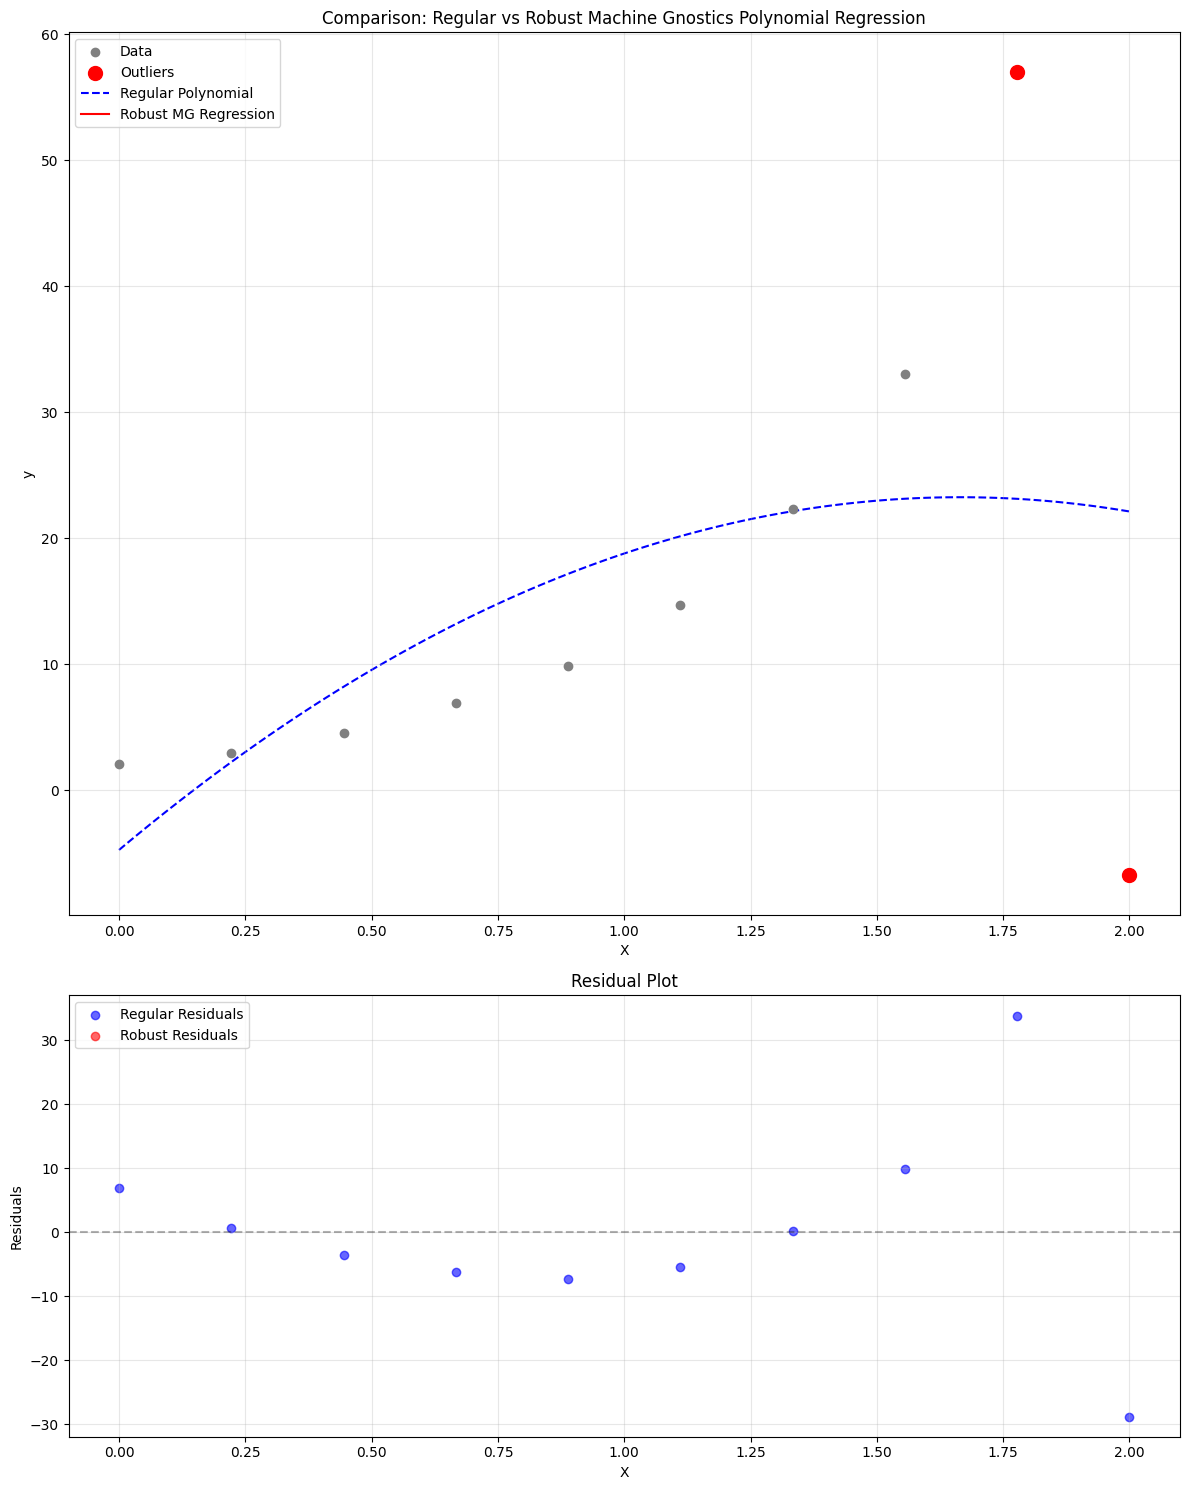

MSE (excluding outliers):
Regular Polynomial: 35.0872
Robust MG Regression: nan

Max Absolute Residuals (excluding outliers):
Regular Polynomial: 9.8999
Robust MG Regression: nan


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Generate data
X = np.linspace(0, 2, 10).reshape(-1, 1)
y = 2.0 * np.exp(1.8 * X.ravel()) + np.random.normal(0, 0.2, 10)
# y[8:] += [80.0, -8.0]  # Add outliers
# Introduce outliers
y[8:] += np.array([8.0, -80.0])  # one high outlier, one low outlier

# Create test points for smooth curve
X_test = np.linspace(0, 2, 100).reshape(-1, 1)

# Fit regular polynomial regression
degree = 2
poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg.fit(X, y)
y_pred_regular = poly_reg.predict(X)  # Predict on training points for residuals
y_pred_regular_test = poly_reg.predict(X_test)  # Predict on test points for curve

# Fit robust Machine Gnostics regression
mg_model = MachineRegression(degree=degree)
mg_model.fit(X, y)
y_pred_robust = mg_model.predict(X)  # Predict on training points for residuals
y_pred_robust_test = mg_model.predict(X_test)  # Predict on test points for curve

# Calculate residuals
residuals_regular = y - y_pred_regular
residuals_robust = y - y_pred_robust

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 15), height_ratios=[2, 1])

# Plot regression curves
ax1.scatter(X, y, color='gray', label='Data', zorder=2)
ax1.scatter(X[8:], y[8:], color='red', s=100, label='Outliers', zorder=3)
ax1.plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
ax1.plot(X_test, y_pred_robust_test, 'r-', label='Robust MG Regression', zorder=1)
ax1.set_xlabel('X')
ax1.set_ylabel('y')
ax1.set_title('Comparison: Regular vs Robust Machine Gnostics Polynomial Regression')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot residuals
ax2.scatter(X, residuals_regular, color='blue', label='Regular Residuals', alpha=0.6)
ax2.scatter(X, residuals_robust, color='red', label='Robust Residuals', alpha=0.6)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.set_xlabel('X')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')
ax2.legend()
ax2.grid(True, alpha=0.3)

# # plot history of loss
# ax3.plot(mg_model.loss_history, color='red', label='Loss History - MG Regression')
# ax3.set_xlabel('Iteration')
# ax3.set_ylabel('Loss')
# ax3.set_title('Loss History of Robust MG Regression - Average Irrelevance')

# ax3.legend()
# ax3.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Print mean squared error for both methods (excluding outliers)
mse_regular = np.mean((y_pred_regular[:-2] - y[:-2])**2)
mse_robust = np.mean((y_pred_robust[:-2] - y[:-2])**2)
print(f"MSE (excluding outliers):")
print(f"Regular Polynomial: {mse_regular:.4f}")
print(f"Robust MG Regression: {mse_robust:.4f}")

# Print max absolute residuals (excluding outliers)
max_resid_regular = np.max(np.abs(residuals_regular[:-2]))
max_resid_robust = np.max(np.abs(residuals_robust[:-2]))
print(f"\nMax Absolute Residuals (excluding outliers):")
print(f"Regular Polynomial: {max_resid_regular:.4f}")
print(f"Robust MG Regression: {max_resid_robust:.4f}")

/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:126: RuntimeWarning: invalid value encountered in power
  q = zz**(2/s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:127: RuntimeWarning: invalid value encountered in power
  q1 = zz**(-2/s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:54: RuntimeWarning: invalid value encountered in power
  return (z / z0) ** (2 / s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:126: RuntimeWarning: invalid value encountered in power
  q = zz**(2/s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:127: RuntimeWarning: invalid value encountered in power
  q1 = zz**(-2/s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:54: RuntimeWarning: invalid value encountered in power
  return (z / z0) ** (2 / s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:1


Cosine Function:
MSE (excluding outliers):
Regular Polynomial: 445.5874
Robust MG Regression: nan

Exponential Function:
MSE (excluding outliers):
Regular Polynomial: 523.2084
Robust MG Regression: 747.8405

Sigmoid Function:
MSE (excluding outliers):
Regular Polynomial: 522.8897
Robust MG Regression: nan

Polynomial Function:
MSE (excluding outliers):
Regular Polynomial: 503.3894
Robust MG Regression: nan


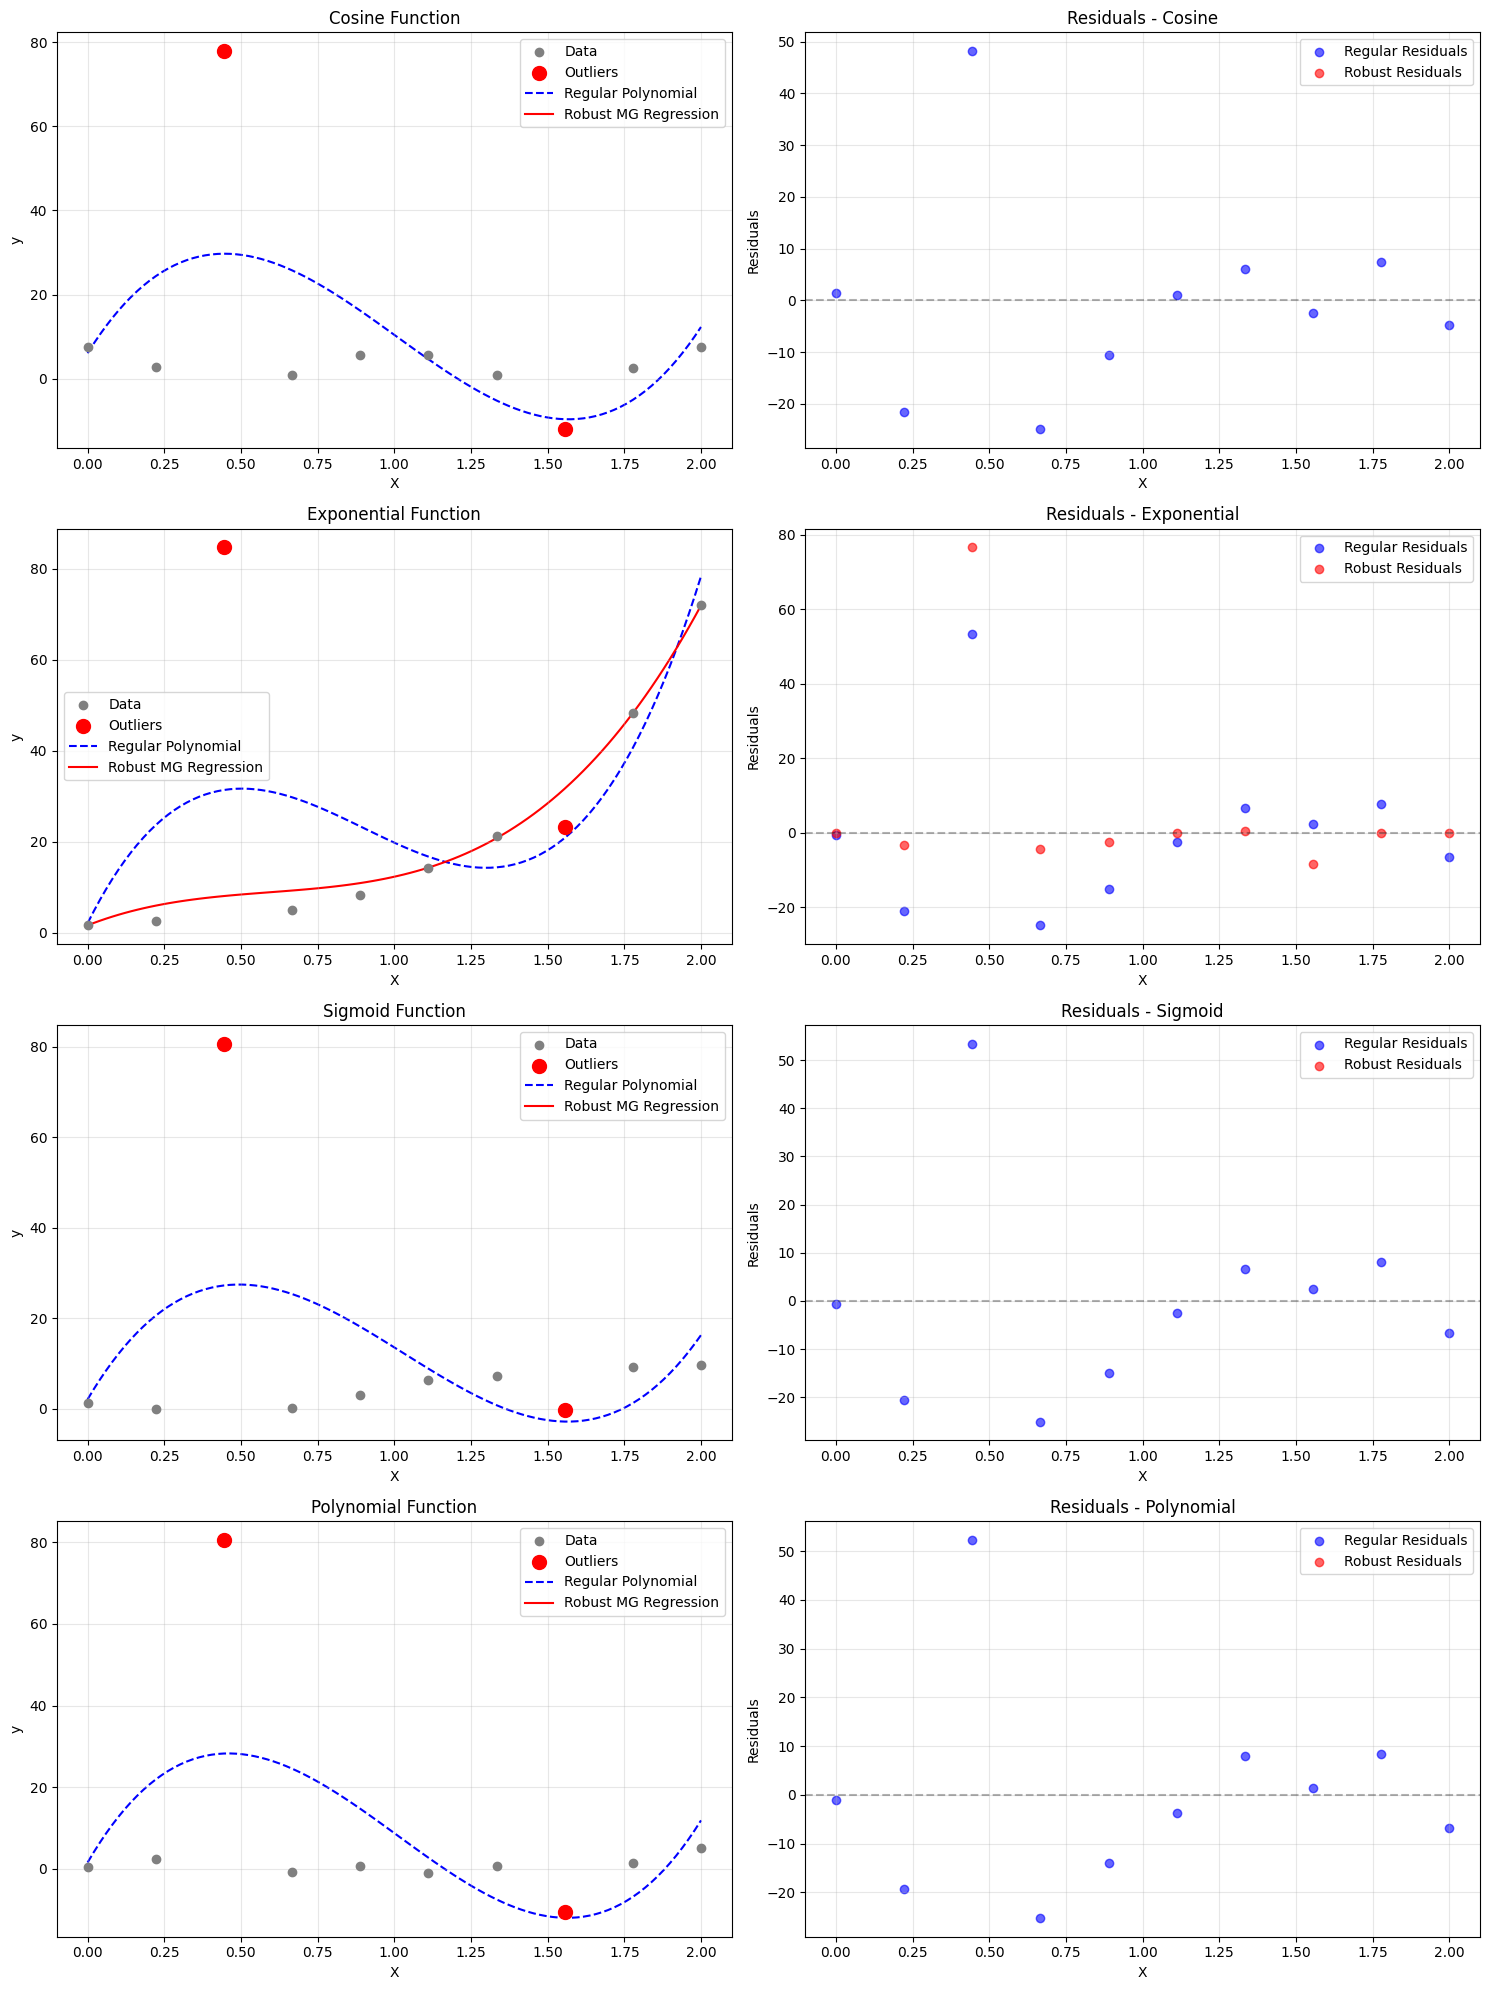

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)
outlier_positions=[2, 7]

# Create multiple test functions
def generate_data(func_type, X, noise_level=0.9, outlier_positions=outlier_positions, outlier_values=[80.0, -10.0]):
    if func_type == 'cosine':
        y = 5 * np.cos(2 * np.pi * X.ravel()) + 2
    elif func_type == 'exponential':
        y = 2.0 * np.exp(1.8 * X.ravel())
    elif func_type == 'sigmoid':
        y = 10.0 * (1 / (1 + np.exp(-5 * (X.ravel() - 1))))
    elif func_type == 'polynomial':
        y = 2 * X.ravel()**3 - 3 * X.ravel()**2 + 1
    
    # Add noise
    y = y + np.random.normal(0, noise_level, len(X))
    
    # Add outliers
    y[outlier_positions] += outlier_values
    return y

# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

for i, func in enumerate(functions):
    # Generate data
    X = np.linspace(0, 2, 10).reshape(-1, 1)
    y = generate_data(func, X)
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    
    # Fit models
    degree = 3  # Increased degree for more complex functions
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    mg_model = MachineRegression(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2)
    # Highlight outliers
    axes[i,0].scatter(X[outlier_positions], y[outlier_positions], color='red', s=100, label='Outliers', zorder=3)
    # axes[i,0].scatter(X[8:], y[2,8], color='red', s=100, label='Outliers', zorder=3)
    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG Regression', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular Residuals', alpha=0.6)
    axes[i,1].scatter(X, residuals_robust, color='red', label='Robust Residuals', alpha=0.6)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Print metrics
    mse_regular = np.mean((y_pred_regular[:-2] - y[:-2])**2)
    mse_robust = np.mean((y_pred_robust[:-2] - y[:-2])**2)
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Robust MG Regression: {mse_robust:.4f}")

plt.tight_layout()
plt.show()

/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:126: RuntimeWarning: invalid value encountered in power
  q = zz**(2/s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:127: RuntimeWarning: invalid value encountered in power
  q1 = zz**(-2/s)
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:54: RuntimeWarning: invalid value encountered in power
  return (z / z0) ** (2 / s)
/Users/nirmal/Documents/np_research/ManGo_code/ManGo/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e+00, tolerance: 7.581e-01
  model = cd_fast.enet_coordinate_descent(
/var/folders/qf/2jw75py95_q8c1t5jmt77sx80000gn/T/ipykernel_49777/71212918.py:126: RuntimeWarning: invalid value encountered in power
  q = zz*


Cosine Function:
MSE (excluding outliers):
Regular Polynomial: 427.6309
Ridge Regression:   530.8462
Lasso Regression:   472.0838
Robust MG:          nan

Exponential Function:
MSE (excluding outliers):
Regular Polynomial: 467.6976
Ridge Regression:   629.4755
Lasso Regression:   553.9167
Robust MG:          nan

Sigmoid Function:
MSE (excluding outliers):
Regular Polynomial: 470.3595
Ridge Regression:   622.5195
Lasso Regression:   561.3465
Robust MG:          nan

Polynomial Function:
MSE (excluding outliers):
Regular Polynomial: 468.6546
Ridge Regression:   631.6724
Lasso Regression:   564.1958
Robust MG:          nan


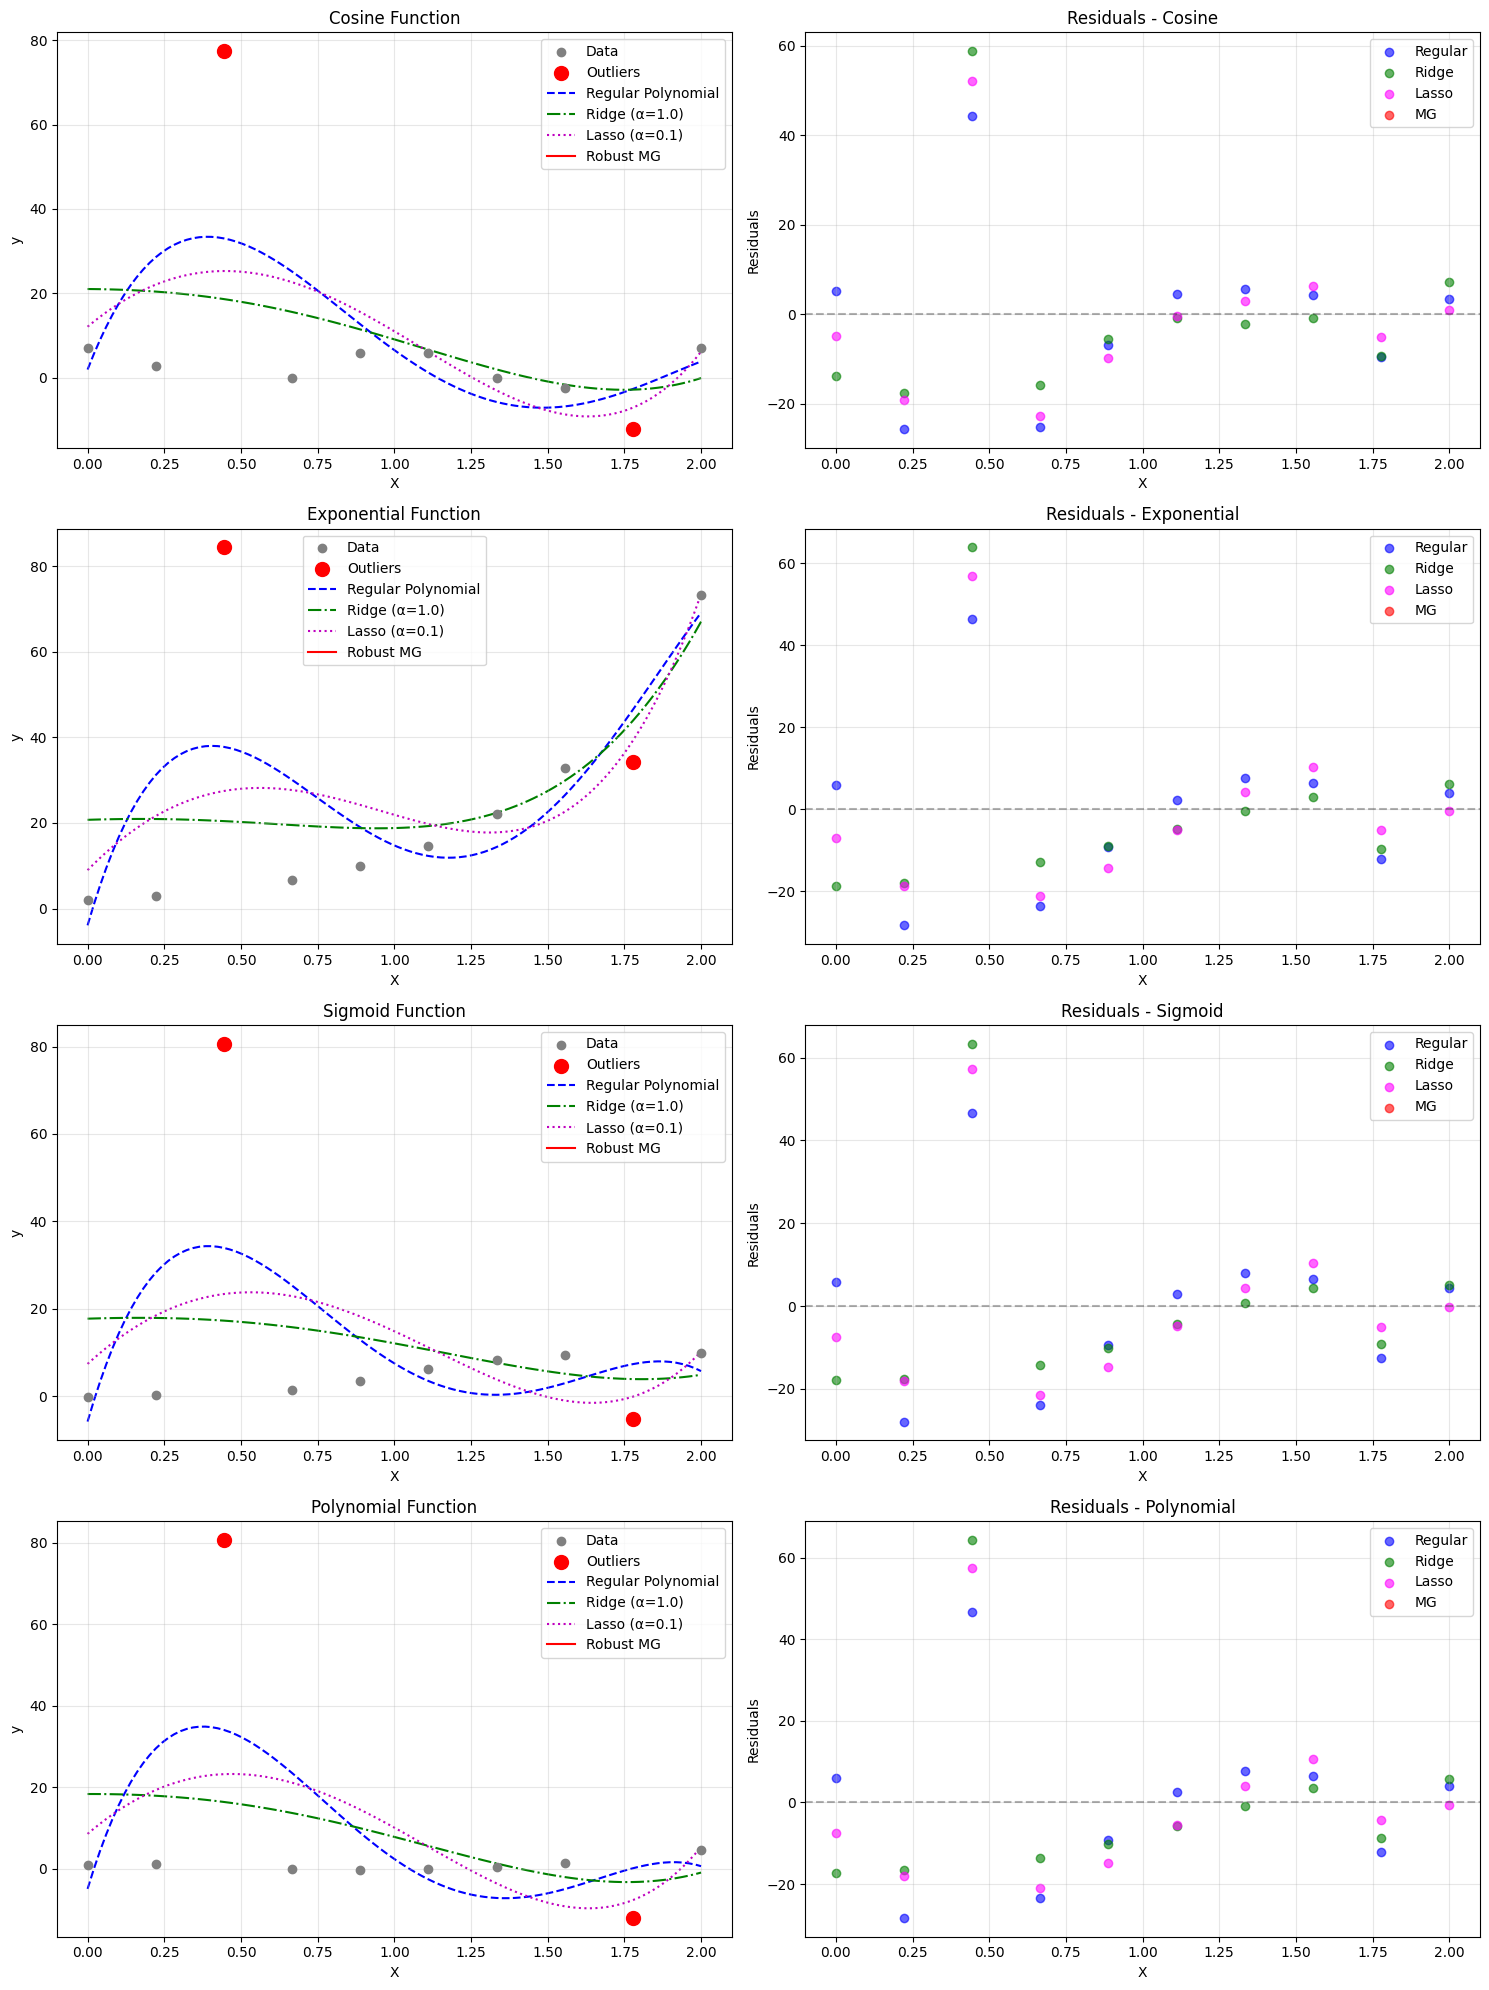

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Create multiple test functions
def generate_data(func_type, X, noise_level=0.2, outlier_positions=[2, 8], outlier_values=[80.0, -15.0]):
    if func_type == 'cosine':
        y = 5 * np.cos(2 * np.pi * X.ravel()) + 2
    elif func_type == 'exponential':
        y = 2.0 * np.exp(1.8 * X.ravel())
    elif func_type == 'sigmoid':
        y = 10.0 * (1 / (1 + np.exp(-5 * (X.ravel() - 1))))
    elif func_type == 'polynomial':
        y = 2 * X.ravel()**3 - 3 * X.ravel()**2 + 1
    
    y = y + np.random.normal(0, noise_level, len(X))
    y[outlier_positions] += outlier_values
    return y

# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

# Set regularization parameters
alpha_ridge = 1.0
alpha_lasso = 0.1

for i, func in enumerate(functions):
    # Generate data
    X = np.linspace(0, 2, 10).reshape(-1, 1)
    y = generate_data(func, X)
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    
    # Fit models
    degree = 4
    # Regular polynomial regression
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    # Ridge regression
    ridge_reg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_ridge))
    ridge_reg.fit(X, y)
    y_pred_ridge = ridge_reg.predict(X)
    y_pred_ridge_test = ridge_reg.predict(X_test)
    
    # Lasso regression
    lasso_reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_lasso))
    lasso_reg.fit(X, y)
    y_pred_lasso = lasso_reg.predict(X)
    y_pred_lasso_test = lasso_reg.predict(X_test)
    
    # Machine Gnostics regression
    mg_model = MachineRegression(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_ridge = y - y_pred_ridge
    residuals_lasso = y - y_pred_lasso
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2)
    # Highlight outliers
    axes[i,0].scatter(X[[2, 8]], y[[2, 8]], color='red', s=100, label='Outliers', zorder=3)

    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_ridge_test, 'g-.', label=f'Ridge (α={alpha_ridge})', zorder=1)
    axes[i,0].plot(X_test, y_pred_lasso_test, 'm:', label=f'Lasso (α={alpha_lasso})', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular', alpha=0.6)
    axes[i,1].scatter(X, residuals_ridge, color='green', label='Ridge', alpha=0.6)
    axes[i,1].scatter(X, residuals_lasso, color='magenta', label='Lasso', alpha=0.6)
    axes[i,1].scatter(X, residuals_robust, color='red', label='MG', alpha=0.6)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Print metrics (excluding outliers)
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    mse_regular = np.mean((y_pred_regular[:-2] - y[:-2])**2)
    mse_ridge = np.mean((y_pred_ridge[:-2] - y[:-2])**2)
    mse_lasso = np.mean((y_pred_lasso[:-2] - y[:-2])**2)
    mse_robust = np.mean((y_pred_robust[:-2] - y[:-2])**2)
    
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Ridge Regression:   {mse_ridge:.4f}")
    print(f"Lasso Regression:   {mse_lasso:.4f}")
    print(f"Robust MG:          {mse_robust:.4f}")

plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error

def calculate_metrics(y_true, y_pred, n_features):
    """
    Calculate regression metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    n_features : int
        Number of features (for adjusted R² calculation)
        
    Returns:
    --------
    dict
        Dictionary containing R², adjusted R², MSE, and RMSE
    """
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    
    # Adjusted R² = 1 - (1 - R²) * (n - 1)/(n - p - 1)
    adj_r2 = 1 - (1 - r2) * (n - 1)/(n - n_features - 1)
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return {
        'R2': r2,
        'Adj_R2': adj_r2,
        'MSE': mse,
        'RMSE': rmse
    }

# ... [previous imports and data generation code remains the same]

for i, func in enumerate(functions):
    # ... [previous data generation and model fitting code remains the same]
    
    # Calculate metrics (excluding outliers)
    X_poly = PolynomialFeatures(degree).fit_transform(X)
    n_features = X_poly.shape[1]
    
    metrics_regular = calculate_metrics(y[:-2], y_pred_regular[:-2], n_features)
    metrics_ridge = calculate_metrics(y[:-2], y_pred_ridge[:-2], n_features)
    metrics_lasso = calculate_metrics(y[:-2], y_pred_lasso[:-2], n_features)
    metrics_robust = calculate_metrics(y[:-2], y_pred_robust[:-2], n_features)
    
    # Print all metrics
    print(f"\n{func.capitalize()} Function Metrics (excluding outliers):")
    print("\nRegular Polynomial:")
    print(f"R² Score:      {metrics_regular['R2']:.4f}")
    print(f"Adjusted R²:   {metrics_regular['Adj_R2']:.4f}")
    print(f"MSE:          {metrics_regular['MSE']:.4f}")
    print(f"RMSE:         {metrics_regular['RMSE']:.4f}")
    
    print("\nRidge Regression:")
    print(f"R² Score:      {metrics_ridge['R2']:.4f}")
    print(f"Adjusted R²:   {metrics_ridge['Adj_R2']:.4f}")
    print(f"MSE:          {metrics_ridge['MSE']:.4f}")
    print(f"RMSE:         {metrics_ridge['RMSE']:.4f}")
    
    print("\nLasso Regression:")
    print(f"R² Score:      {metrics_lasso['R2']:.4f}")
    print(f"Adjusted R²:   {metrics_lasso['Adj_R2']:.4f}")
    print(f"MSE:          {metrics_lasso['MSE']:.4f}")
    print(f"RMSE:         {metrics_lasso['RMSE']:.4f}")
    
    print("\nRobust MG Regression:")
    print(f"R² Score:      {metrics_robust['R2']:.4f}")
    print(f"Adjusted R²:   {metrics_robust['Adj_R2']:.4f}")
    print(f"MSE:          {metrics_robust['MSE']:.4f}")
    print(f"RMSE:         {metrics_robust['RMSE']:.4f}")
    
    # Optional: Add metrics to plot title
    axes[i,0].set_title(f"{func.capitalize()} Function\nMG R² = {metrics_robust['R2']:.3f}")

# ... [rest of the plotting code remains the same]

ValueError: Input contains NaN.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Create multiple test functions
def generate_data(func_type, X, noise_level=1.8, outlier_positions=[1, 2], outlier_values=[80.0, -15.0]):
    if func_type == 'cosine':
        y = 15 * np.cos(2 * np.pi * X.ravel()) + 2
    elif func_type == 'exponential':
        y = 2.0 * np.exp(1.8 * X.ravel())
    elif func_type == 'sigmoid':
        y = 1.0 * (1 / (1 + np.exp(-5 * (X.ravel() - 1))))
    elif func_type == 'polynomial':
        y = 0.05 * X.ravel()**3 - 30 * X.ravel()**2 + 1
    
    y = y + np.random.normal(0, noise_level, len(X))
    y[outlier_positions] += outlier_values
    return y

# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

# Set regularization parameters
alpha_ridge = 1.0
alpha_lasso = 0.1

for i, func in enumerate(functions):
    # Generate data - changed to 5 points
    X = np.linspace(0, 2, 6).reshape(-1, 1)  # 5 points total
    y = generate_data(func, X)
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    
    # Fit models
    degree = 2  # Reduced degree due to fewer points
    # Regular polynomial regression
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    # Ridge regression
    ridge_reg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_ridge))
    ridge_reg.fit(X, y)
    y_pred_ridge = ridge_reg.predict(X)
    y_pred_ridge_test = ridge_reg.predict(X_test)
    
    # Lasso regression
    lasso_reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_lasso))
    lasso_reg.fit(X, y)
    y_pred_lasso = lasso_reg.predict(X)
    y_pred_lasso_test = lasso_reg.predict(X_test)
    
    # Machine Gnostics regression
    mg_model = MachineRegression(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_ridge = y - y_pred_ridge
    residuals_lasso = y - y_pred_lasso
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2)
    # Highlight outliers
    axes[i,0].scatter(X[[1, 2]], y[[1, 2]], color='red', s=100, label='Outliers', zorder=3)

    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_ridge_test, 'g-.', label=f'Ridge (α={alpha_ridge})', zorder=1)
    axes[i,0].plot(X_test, y_pred_lasso_test, 'm:', label=f'Lasso (α={alpha_lasso})', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular', alpha=0.6)
    axes[i,1].scatter(X, residuals_ridge, color='green', label='Ridge', alpha=0.6)
    axes[i,1].scatter(X, residuals_lasso, color='magenta', label='Lasso', alpha=0.6)
    axes[i,1].scatter(X, residuals_robust, color='red', label='MG', alpha=0.6)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Calculate metrics excluding outliers
    good_indices = [0, 2, 4]  # Indices of non-outlier points
    mse_regular = np.mean((y_pred_regular[good_indices] - y[good_indices])**2)
    mse_ridge = np.mean((y_pred_ridge[good_indices] - y[good_indices])**2)
    mse_lasso = np.mean((y_pred_lasso[good_indices] - y[good_indices])**2)
    mse_robust = np.mean((y_pred_robust[good_indices] - y[good_indices])**2)
    
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Ridge Regression:   {mse_ridge:.4f}")
    print(f"Lasso Regression:   {mse_lasso:.4f}")
    print(f"Robust MG:          {mse_robust:.4f}")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)

def generate_data(func_type, X, params):
    """Generate synthetic data with different profiles."""
    # Base function
    if func_type == 'cosine':
        y = params['amplitude'] * np.cos(params['frequency'] * X.ravel()) + params['offset']
    elif func_type == 'exponential':
        y = params['amplitude'] * np.exp(params['rate'] * X.ravel())
    elif func_type == 'sigmoid':
        y = params['amplitude'] / (1 + np.exp(-params['rate'] * (X.ravel() - params['midpoint'])))
    elif func_type == 'polynomial':
        y = (params['a'] * X.ravel()**3 + 
             params['b'] * X.ravel()**2 + 
             params['c'] * X.ravel() + 
             params['d'])
    
    # Add base noise
    y_ = y + np.random.normal(0, params['noise_level'], len(X))
    
    # Add trend if specified
    if params['trend'] != 0:
        y_ += params['trend'] * X.ravel()
    
    # Add outliers
    if params['outlier_mode'] == 'random':
        # Random outliers
        n_outliers = int(len(X) * params['outlier_fraction'])
        outlier_idx = np.random.choice(len(X), n_outliers, replace=False)
        outlier_values = np.random.normal(params['outlier_mean'], 
                                        params['outlier_std'], 
                                        n_outliers)
        y_[outlier_idx] += outlier_values
    elif params['outlier_mode'] == 'systematic':
        # Systematic outliers at specific positions
        y_[params['outlier_positions']] += params['outlier_values']
    
    return y, y_

# Define test profiles with different characteristics
test_profiles = {
    'cosine': {
        'amplitude': 15,
        'frequency': 2 * np.pi,
        'offset': 2,
        'noise_level': 5,
        'trend': 2,  # Linear trend
        'outlier_mode': 'random',
        'outlier_fraction': 0.1,
        'outlier_mean': 0,
        'outlier_std': 50
    },
    'exponential': {
        'amplitude': 2,
        'rate': 1.8,
        'noise_level': 8,
        'trend': -1,  # Negative trend
        'outlier_mode': 'systematic',
        'outlier_positions': [20, 40, 60, 80],
        'outlier_values': [80, -60, 100, -80]
    },
    'sigmoid': {
        'amplitude': 100,
        'rate': 5,
        'midpoint': 1,
        'noise_level': 10,
        'trend': 0,
        'outlier_mode': 'random',
        'outlier_fraction': 0.15,
        'outlier_mean': 50,
        'outlier_std': 30
    },
    'polynomial': {
        'a': 0.005,
        'b': -0.3,
        'c': 5,
        'd': 70,
        'noise_level': 15,
        'trend': 1.5,
        'outlier_mode': 'systematic',
        'outlier_positions': [10, 30, 50, 70, 90],
        'outlier_values': [-60, 80, -70, 90, -50]
    }
}

# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

# Set regularization parameters
alpha_ridge = 1.0
alpha_lasso = 0.1

for i, func in enumerate(functions):
    # Generate data
    X = np.linspace(0, 2, 100).reshape(-1, 1)
    y, y_ = generate_data(func, X, test_profiles[func])
    X_test = np.linspace(0, 2, 200).reshape(-1, 1)
    
    # ... rest of the code remains the same ...
    
    # Fit models
    degree = 5  # Reduced degree due to fewer points
    # Regular polynomial regression
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    # Ridge regression
    ridge_reg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_ridge))
    ridge_reg.fit(X, y)
    y_pred_ridge = ridge_reg.predict(X)
    y_pred_ridge_test = ridge_reg.predict(X_test)
    
    # Lasso regression
    lasso_reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_lasso))
    lasso_reg.fit(X, y)
    y_pred_lasso = lasso_reg.predict(X)
    y_pred_lasso_test = lasso_reg.predict(X_test)
    
    # Machine Gnostics regression
    mg_model = MachineRegression(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_ridge = y - y_pred_ridge
    residuals_lasso = y - y_pred_lasso
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y_, color='gray', label='Data', zorder=2, alpha=0.3)
    # true data
    axes[i,0].plot(X, y, color='g', label='Data', zorder=2, alpha=0.3)
    # true data)

    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_ridge_test, 'g-.', label=f'Ridge (α={alpha_ridge})', zorder=1)
    axes[i,0].plot(X_test, y_pred_lasso_test, 'm:', label=f'Lasso (α={alpha_lasso})', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular', alpha=0.3)
    axes[i,1].scatter(X, residuals_ridge, color='green', label='Ridge', alpha=0.63)
    axes[i,1].scatter(X, residuals_lasso, color='magenta', label='Lasso', alpha=0.3)
    axes[i,1].scatter(X, residuals_robust, color='red', label='MG', alpha=0.3)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Calculate metrics excluding outliers
    good_indices = [0, 2, 4]  # Indices of non-outlier points
    mse_regular = np.mean((y_pred_regular[good_indices] - y[good_indices])**2)
    mse_ridge = np.mean((y_pred_ridge[good_indices] - y[good_indices])**2)
    mse_lasso = np.mean((y_pred_lasso[good_indices] - y[good_indices])**2)
    mse_robust = np.mean((y_pred_robust[good_indices] - y[good_indices])**2)
    
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Ridge Regression:   {mse_ridge:.4f}")
    print(f"Lasso Regression:   {mse_lasso:.4f}")
    print(f"Robust MG:          {mse_robust:.4f}")

plt.tight_layout()
plt.show()

In [ ]:
def generate_data(func_type, X, params):
    """Generate synthetic data with different profiles and outlier clusters."""
    # Base function
    if func_type == 'cosine':
        y = params['amplitude'] * np.cos(params['frequency'] * X.ravel()) + params['offset']
    elif func_type == 'exponential':
        y = params['amplitude'] * np.exp(params['rate'] * X.ravel())
    elif func_type == 'sigmoid':
        y = params['amplitude'] / (1 + np.exp(-params['rate'] * (X.ravel() - params['midpoint'])))
    elif func_type == 'polynomial':
        y = (params['a'] * X.ravel()**3 + 
             params['b'] * X.ravel()**2 + 
             params['c'] * X.ravel() + 
             params['d'])
    
    # Add base noise
    y_ = y + np.random.normal(0, params['noise_level'], len(X))
    
    # Add trend if specified
    if params['trend'] != 0:
        y_ += params['trend'] * X.ravel()
    
    # Add outlier clusters
    for cluster in params['outlier_clusters']:
        center = cluster['center']
        width = cluster['width']
        strength = cluster['strength']
        
        # Create cluster of outliers
        cluster_mask = np.abs(X.ravel() - center) < width/2
        n_points = np.sum(cluster_mask)
        
        if n_points > 0:
            # Generate cluster noise
            cluster_noise = np.random.normal(
                strength['mean'], 
                strength['std'], 
                n_points
            )
            y[cluster_mask] += cluster_noise
    
    return y, y_

# Define test profiles with outlier clusters
test_profiles = {
    'cosine': {
        'amplitude': 15,
        'frequency': 2 * np.pi,
        'offset': 2,
        'noise_level': 5,
        'trend': 2,
        'outlier_clusters': [
            {'center': 0.5, 'width': 0.2, 'strength': {'mean': 30, 'std': 10}},
            # {'center': 1.2, 'width': 0.3, 'strength': {'mean': -40, 'std': 15}},
            # {'center': 1.8, 'width': 0.2, 'strength': {'mean': 60, 'std': 12}}
        ]
    },
    'exponential': {
        'amplitude': 2,
        'rate': 1.8,
        'noise_level': 8,
        'trend': -1,
        'outlier_clusters': [
            # {'center': 0.3, 'width': 0.25, 'strength': {'mean': -60, 'std': 15}},
            {'center': 1.0, 'width': 0.2, 'strength': {'mean': 80, 'std': 20}},
            # {'center': 1.7, 'width': 0.3, 'strength': {'mean': -70, 'std': 18}}
        ]
    },
    'sigmoid': {
        'amplitude': 100,
        'rate': 5,
        'midpoint': 1,
        'noise_level': 10,
        'trend': 0,
        'outlier_clusters': [
            {'center': 0.4, 'width': 0.2, 'strength': {'mean': 90, 'std': 15}},
            # {'center': 1.1, 'width': 0.25, 'strength': {'mean': -50, 'std': 12}},
            # {'center': 1.6, 'width': 0.3, 'strength': {'mean': 40, 'std': 10}}
        ]
    },
    'polynomial': {
        'a': 0.005,
        'b': -0.3,
        'c': 5,
        'd': 70,
        'noise_level': 15,
        'trend': 1.5,
        'outlier_clusters': [
            # {'center': 0.6, 'width': 0.3, 'strength': {'mean': -80, 'std': 20}},
            {'center': 1.3, 'width': 0.2, 'strength': {'mean': 90, 'std': 15}},
            # {'center': 1.9, 'width': 0.25, 'strength': {'mean': -60, 'std': 18}}
        ]
    }
}

In [ ]:
# Test different functions
functions = ['cosine', 'exponential', 'sigmoid', 'polynomial']
fig, axes = plt.subplots(len(functions), 2, figsize=(15, 5*len(functions)))

# Set regularization parameters
alpha_ridge = 1.0
alpha_lasso = 0.1

for i, func in enumerate(functions):
    # Generate data
    X = np.linspace(0, 2, 100).reshape(-1, 1)
    y, y_clean = generate_data(func, X, test_profiles[func])
    X_test = np.linspace(0, 2, 200).reshape(-1, 1)
    
    # ... rest of the code remains the same ...
    
    # Fit models
    degree = 3  # Reduced degree due to fewer points
    # Regular polynomial regression
    poly_reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_reg.fit(X, y)
    y_pred_regular = poly_reg.predict(X)
    y_pred_regular_test = poly_reg.predict(X_test)
    
    # Ridge regression
    ridge_reg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha_ridge))
    ridge_reg.fit(X, y)
    y_pred_ridge = ridge_reg.predict(X)
    y_pred_ridge_test = ridge_reg.predict(X_test)
    
    # Lasso regression
    lasso_reg = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha_lasso))
    lasso_reg.fit(X, y)
    y_pred_lasso = lasso_reg.predict(X)
    y_pred_lasso_test = lasso_reg.predict(X_test)
    
    # Machine Gnostics regression
    mg_model = MachineRegression(degree=degree)
    mg_model.fit(X, y)
    y_pred_robust = mg_model.predict(X)
    y_pred_robust_test = mg_model.predict(X_test)
    
    # Calculate residuals
    residuals_regular = y - y_pred_regular
    residuals_ridge = y - y_pred_ridge
    residuals_lasso = y - y_pred_lasso
    residuals_robust = y - y_pred_robust
    
    # Plot regression curves
    axes[i,0].scatter(X, y, color='gray', label='Data', zorder=2, alpha=0.3)
    # line plot -true data
    axes[i,0].plot(X, y_clean, color='g', alpha=0.1, label='True Data', zorder=2)
    # Highlight outliers
    # axes[i,0].scatter(X[[1, 2]], y[[1, 2]], color='red', s=100, label='Outliers', zorder=3)

    axes[i,0].plot(X_test, y_pred_regular_test, 'b--', label='Regular Polynomial', zorder=1)
    axes[i,0].plot(X_test, y_pred_ridge_test, 'g-.', label=f'Ridge (α={alpha_ridge})', zorder=1)
    axes[i,0].plot(X_test, y_pred_lasso_test, 'm:', label=f'Lasso (α={alpha_lasso})', zorder=1)
    axes[i,0].plot(X_test, y_pred_robust_test, 'r-', label='Robust MG', zorder=1)
    axes[i,0].set_xlabel('X')
    axes[i,0].set_ylabel('y')
    axes[i,0].set_title(f'{func.capitalize()} Function')
    axes[i,0].legend()
    axes[i,0].grid(True, alpha=0.3)
    
    # Plot residuals
    axes[i,1].scatter(X, residuals_regular, color='blue', label='Regular', alpha=0.3)
    axes[i,1].scatter(X, residuals_ridge, color='green', label='Ridge', alpha=0.63)
    axes[i,1].scatter(X, residuals_lasso, color='magenta', label='Lasso', alpha=0.3)
    axes[i,1].scatter(X, residuals_robust, color='red', label='MG', alpha=0.3)
    axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[i,1].set_xlabel('X')
    axes[i,1].set_ylabel('Residuals')
    axes[i,1].set_title(f'Residuals - {func.capitalize()}')
    axes[i,1].legend()
    axes[i,1].grid(True, alpha=0.3)
    
    # Calculate metrics excluding outliers
    good_indices = [0, 2, 4]  # Indices of non-outlier points
    mse_regular = np.mean((y_pred_regular[good_indices] - y[good_indices])**2)
    mse_ridge = np.mean((y_pred_ridge[good_indices] - y[good_indices])**2)
    mse_lasso = np.mean((y_pred_lasso[good_indices] - y[good_indices])**2)
    mse_robust = np.mean((y_pred_robust[good_indices] - y[good_indices])**2)
    
    print(f"\n{func.capitalize()} Function:")
    print(f"MSE (excluding outliers):")
    print(f"Regular Polynomial: {mse_regular:.4f}")
    print(f"Ridge Regression:   {mse_ridge:.4f}")
    print(f"Lasso Regression:   {mse_lasso:.4f}")
    print(f"Robust MG:          {mse_robust:.4f}")

plt.tight_layout()
plt.show()